## ANLP Assignment 1: Sentiment Analysis
### Christopher Hamilton,  a1766121

In [3]:
import json
import os 

import pandas as pd
import numpy as np
from langdetect import detect as detect_language

### 1. Reading dataset and initial pre-processing

In [4]:
def read_json_to_df(file_name):
    data = []
    with open(file_name) as data_file:
        for line in data_file:
            data.append(json.loads(line))    

    return pd.json_normalize(data)

train_df = read_json_to_df("hotel_reviews_train.json")

In [5]:
train_df.head()

,title,text,date_stayed,offering_id,num_helpful_votes,date,id,via_mobile,ratings.service,ratings.cleanliness,...,ratings.rooms,author.username,author.num_reviews,author.id,author.location,author.num_cities,author.num_helpful_votes,author.num_type_reviews,ratings.check_in_front_desk,ratings.business_service_(e_g_internet_access)
0,“Horrible experience”,First of all we got there and they didn't have...,September 2012,80138,0,"September 19, 2012",140716137,False,1.0,2.0,...,1.0,Kh3RD,1.0,AB404BB664D653ECF79DE0E0867F6D34,"Las Vegas, Nevada",NaN,NaN,NaN,NaN,NaN
1,“Stay Away”,Found Racist graffiti in the room. Request to ...,June 2011,240151,1,"June 27, 2011",114807323,False,1.0,1.0,...,NaN,TheUglyPhotographer,4.0,BB116F87FE8F9AB356F63853BFD32FFE,"Oceanside, California",3.0,4.0,4.0,NaN,NaN
2,“Great location and service”,Close to Union Square - hotel is a bit of a ma...,October 2010,80793,0,"October 25, 2010",84805430,False,4.0,5.0,...,4.0,Moonstonemoclips,48.0,F3D0CF371B788300E73A1413B2DABB4B,Kirkland,31.0,27.0,32.0,NaN,NaN
3,“I will never go back here again!”,I had a bad vibe about this place from the mom...,June 2012,111418,1,"June 28, 2012",132971117,False,3.0,2.0,...,1.0,JoanellenJ,22.0,BC6BC07F81B768F78B6CE17A18762C11,New York,10.0,9.0,5.0,NaN,NaN
4,“Ripped off our VISA card after departure”,"After we received our ""final"" bill and left th...",January 2012,671150,3,"February 4, 2012",124104157,False,NaN,NaN,...,NaN,Lynnworks,3.0,F7E9D044FA2554FD06A871289312E043,Providence,3.0,7.0,3.0,NaN,NaN


In [6]:
predict_overall_train_df = train_df[["title", "text", "ratings.overall"]]

predict_overall_train_df.head()

,title,text,ratings.overall
0,“Horrible experience”,First of all we got there and they didn't have...,1.0
1,“Stay Away”,Found Racist graffiti in the room. Request to ...,1.0
2,“Great location and service”,Close to Union Square - hotel is a bit of a ma...,4.0
3,“I will never go back here again!”,I had a bad vibe about this place from the mom...,2.0
4,“Ripped off our VISA card after departure”,"After we received our ""final"" bill and left th...",1.0


In [7]:
predict_overall_train_df.loc[:,'title'] = ["".join(filter(lambda c: str.isalnum(c) or str.isspace(c), char)) for char in predict_overall_train_df.title]
predict_overall_train_df.loc[:,'text'] = ["".join(filter(lambda c: str.isalnum(c) or str.isspace(c), char)) for char in predict_overall_train_df.text]

In [8]:
predict_overall_train_df.head()

,title,text,ratings.overall
0,Horrible experience,First of all we got there and they didnt have ...,1.0
1,Stay Away,Found Racist graffiti in the room Request to c...,1.0
2,Great location and service,Close to Union Square hotel is a bit of a maz...,4.0
3,I will never go back here again,I had a bad vibe about this place from the mom...,2.0
4,Ripped off our VISA card after departure,After we received our final bill and left the ...,1.0


In [9]:
def filter_english_reviews(df):
    def is_english(text):
        try:
            return detect_language(text) == "en"
        except:
            return False

    return df[df["title"].apply(is_english) & df["text"].apply(is_english)]

In [10]:
predict_overall_train_df = filter_english_reviews(predict_overall_train_df)

In [11]:
predict_overall_train_df.head()

,title,text,ratings.overall
2,Great location and service,Close to Union Square hotel is a bit of a maz...,4.0
3,I will never go back here again,I had a bad vibe about this place from the mom...,2.0
4,Ripped off our VISA card after departure,After we received our final bill and left the ...,1.0
5,A great location,Steps to Grand Central a very well situated ho...,4.0
6,Its all about the Location,This Hotel is located right in the heart of Sa...,3.0


In [12]:
print(train_df.info())
print(predict_overall_train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 24 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   title                                           24000 non-null  object 
 1   text                                            24000 non-null  object 
 2   date_stayed                                     23050 non-null  object 
 3   offering_id                                     24000 non-null  int64  
 4   num_helpful_votes                               24000 non-null  int64  
 5   date                                            24000 non-null  object 
 6   id                                              24000 non-null  int64  
 7   via_mobile                                      24000 non-null  bool   
 8   ratings.service                                 21550 non-null  float64
 9   ratings.cleanliness                    

### 2. Exploratory Data Analysis (EDA)

In [13]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /home/chris/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/chris/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

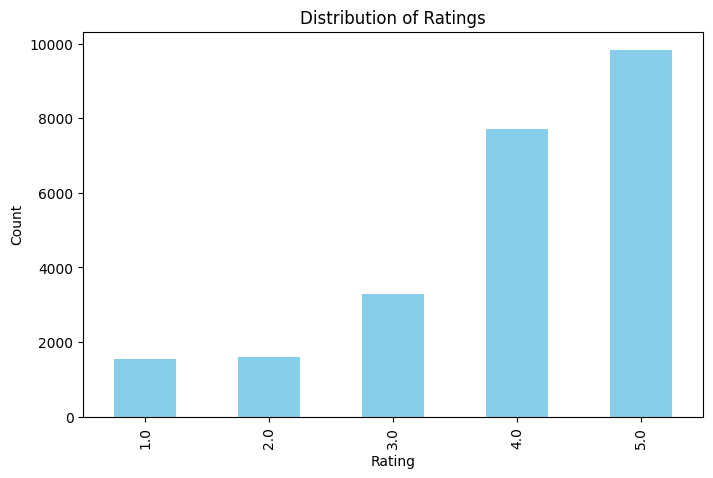

In [14]:
import matplotlib.pyplot as plt

# Plot distribution of ratings
train_df['ratings.overall'].value_counts().sort_index().plot(kind='bar', figsize=(8,5), color='skyblue')

plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)  # Remove common words
X = vectorizer.fit_transform(train_df["text"])

# Convert to DataFrame
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

correlations = tfidf_df.corrwith(train_df["ratings.overall"])
correlations = correlations.sort_values(ascending=False)  # Sort by importance

# Find words with the weakest correlation (near zero)
non_predictive_words = correlations.sort_values(key=lambda x: np.abs(x))
print("Non-Predictive Words:\n", non_predictive_words.head(10))

# Display top positive and negative correlated words
print("Most Positive Words:\n", correlations.head(10))
print("\nMost Negative Words:\n", correlations.tail(10))

Non-Predictive Words:
 jane         0.000003
familiar     0.000005
teenagers    0.000028
39          -0.000029
extend      -0.000033
couches      0.000035
doughnuts   -0.000042
bldg        -0.000043
queue        0.000045
keeping      0.000047
dtype: float64
Most Positive Words:
 great          0.251586
staff          0.196470
friendly       0.167828
comfortable    0.159558
helpful        0.156769
wonderful      0.153227
excellent      0.148437
perfect        0.147401
highly         0.132126
loved          0.126517
dtype: float64

Most Negative Words:
 carpet     -0.153744
bad        -0.155436
room       -0.156964
horrible   -0.164654
terrible   -0.168106
rude       -0.182339
said       -0.185605
worst      -0.212137
dirty      -0.233399
told       -0.250588
dtype: float64


In [27]:
# Split all reviews into words and find unique ones
all_words_text = predict_overall_train_df.text.apply(nltk.word_tokenize)
all_words_title = predict_overall_train_df.title.apply(nltk.word_tokenize)

all_words = pd.concat([all_words_text, all_words_title])
unique_words = np.unique(all_words)

print("Total Unique Words:", len(unique_words))


Total Unique Words: 35730


In [ ]:
# Word frequency plots are used to visualize the most common words in a dataset.

from collections import Counter
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

tokens = [
    word.lower() for sentence in unique_words.tolist()
    for s in sentence
    for word in word_tokenize(s)
    if word.isalnum() and word.lower() not in stop_words
]

word_freq = Counter(tokens)

plt.figure(figsize=(12, 5))
plt.bar(word_freq.keys(), word_freq.values())
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Plot")
plt.show()


In [ ]:
# Identifying common N-grams: N-grams are sequences of words. 
# Identifying common n-grams can give insight into the most common phrases in the dataset.

import nltk
from nltk import ngrams
from collections import Counter
import matplotlib.pyplot as plt

# Function to generate n-grams
def generate_ngrams(text, n):
    n_grams = ngrams(text, n)
    return [' '.join(gram) for gram in n_grams]

# Specify the value of n for n-grams
n_value = 3  # You can change this value to see different n-grams, e.g., 2 for bigrams, 3 for trigrams, etc.

# Generate n-grams
ngrams_list = generate_ngrams(tokens, n_value)

# Count the occurrences of each n-gram
ngrams_count = Counter(ngrams_list)

# Display the distribution
print(f"Distribution of {n_value}-grams:")
for ngram, count in ngrams_count.items():
    print(f"{ngram}: {count}")

# Plot the distribution
labels, values = zip(*ngrams_count.items())
indexes = range(len(labels))

plt.bar(indexes, values)
plt.xlabel(f'{n_value}-grams')
plt.ylabel('Frequency')
plt.xticks(indexes, labels, rotation='vertical')
plt.title(f'Distribution of {n_value}-grams')
plt.show()

### 3. Selection and training Machine Learning models

### 4. Experiment with VADER sentiment lexicon

### 5. Final testing on test set and discussion of results

### 6. Propose a method to predict aspects 

***(COMP SCI 7417 and COMP SCI 7717 only)***

### 7. Reflection on the ***Product*** development.

### 9. References

https://pandas.pydata.org/pandas-docs/version/1.2.0/reference/api/pandas.json_normalize.html

https://www.analyticsvidhya.com/blog/2022/07/step-by-step-exploratory-data-analysis-eda-using-python/

https://pawarbi.github.io/blog/pandas/numpy/data-cleaning/2021/03/05/removing-non-alphanumeric-symbols-characters-from-column-numpy-pandas-dataframe.html


### Appendix